# Emotion Detetion NLP Sentiment Analysis

1.0 Import Libraries

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style, rcParams
style.use('seaborn-white')
rcParams['figure.figsize'] = 10,5
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
import re

In [3]:
# Import NLP Libaray

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [50]:
# Import Sci-Kit Learn Library

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay

In [8]:
train_df = pd.read_csv('train.txt', delimiter = ';' , names = ['text', 'label'])
val_df = pd.read_csv('val.txt', delimiter = ';', names = ['text','label'])

In [9]:
# concat train and validation data frames to use as cross validation and a separate dataset
df = pd.concat([train_df,val_df])
print("Shape of Dataframe:",df.shape)

Shape of Dataframe: (18000, 2)


In [10]:
df.reset_index(inplace = True, drop = True)

In [11]:
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


/Users/nickseah/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

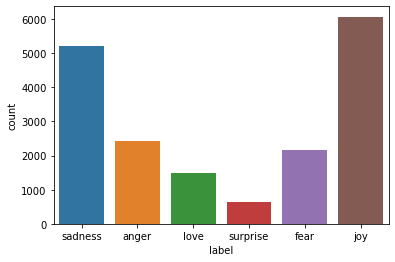

In [12]:
sns.countplot(df.label)

1) Positive - Joy, Love, surprise - Coded as 1

2) Negative - anger, sadness, fear - Coded as 0

In [13]:
# Custom Encoder

def custom_encoder(df):
    df.replace(to_replace = "surprise", value = 1, inplace = True)
    df.replace(to_replace ="love", value =1, inplace=True)
    df.replace(to_replace ="joy", value =1, inplace=True)
    df.replace(to_replace ="fear", value =0, inplace=True)
    df.replace(to_replace ="anger", value =0, inplace=True)
    df.replace(to_replace ="sadness", value =0, inplace=True)

In [15]:
# Apply Function
custom_encoder(df['label'])

/Users/nickseah/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

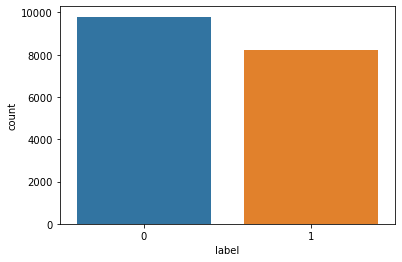

In [16]:
sns.countplot(df.label)

In [17]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,1
4,i am feeling grouchy,0


## Preprocessing

In [18]:
lm = WordNetLemmatizer()

### Function to pre-process data
1) Iterate through each record and removing non alphabetical characters using regular expressions

2) Convert the string to lowercase as the word Good is not the same as good, which will cause issues because multiple vectors will be created for the same word

3) Then we will check for stopwords in the data and get rid of them. Stopwords are commonly used words in a sentence such as "the","an","to" etc. which do not add much value.

4) Then, we will perform lemmatization on each word,i.e. change the different forms of word into a single item called as lemma. A lemma is a base form of a word. For example, run, running and runs are all forms of same lexeme where run is the lemma. Hence, we are converting all occurrences of same lexeme to it's respective lemma.

5) And, then return a corpus of processed data

In [23]:
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [24]:
corpus = text_transformation(df['text'])

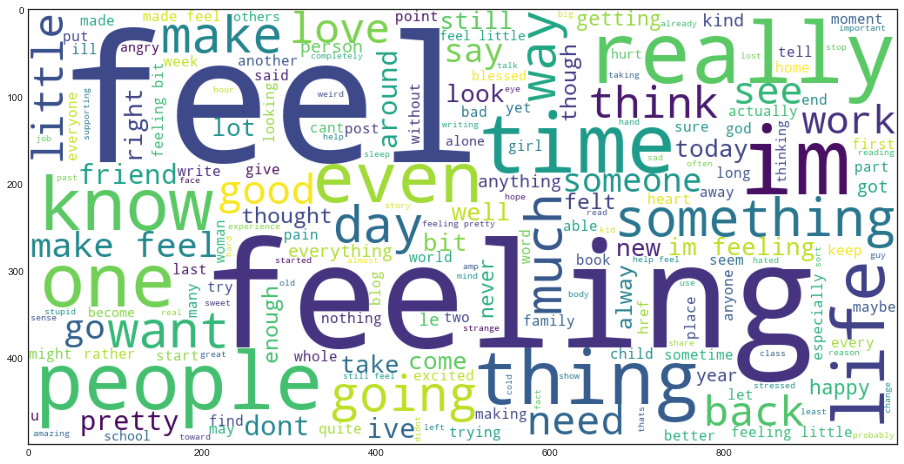

In [27]:
rcParams['figure.figsize'] = 20,8
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)

wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
cv = CountVectorizer(ngram_range = (1,2))
traindata = cv.fit_transform(corpus)

In [31]:
X = traindata
y = df.label

## Model Building

We will use the RandomForestClassifier to start

In [34]:
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [50, 100],
             'max_depth': [10, None],
             }

In [35]:
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(X,y)
grid_search.best_params_

{'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}

In [36]:
for i in range(6):
    print('Parameters: ',grid_search.cv_results_['params'][i])
    print('Mean Test Score: ',grid_search.cv_results_['mean_test_score'][i])
    print('Rank: ',grid_search.cv_results_['rank_test_score'][i])

Parameters:  {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 50}
Mean Test Score:  0.5566666666666666
Rank:  5
Parameters:  {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
Mean Test Score:  0.5471111111111112
Rank:  8
Parameters:  {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
Mean Test Score:  0.5559444444444445
Rank:  6
Parameters:  {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Mean Test Score:  0.5497222222222222
Rank:  7
Parameters:  {'max_depth': None, 'max_features': 'auto', 'n_estimators': 50}
Mean Test Score:  0.9508333333333333
Rank:  3
Parameters:  {'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}
Mean Test Score:  0.9555
Rank:  1


### Best CV Parameters for the final model

In [39]:
rfc = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],
                                      max_depth=grid_search.best_params_['max_depth'],
                                      n_estimators=grid_search.best_params_['n_estimators']
                            )

## Train the new model

In [41]:
rfc.fit(X,y)


RandomForestClassifier()

In [42]:
test_df = pd.read_csv('test.txt',delimiter=';',names=['text','label'])

In [43]:
X_test,y_test = test_df.text,test_df.label
#encode the labels into two classes , 0 and 1
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
testdata = cv.transform(test_corpus)
#predict the target
predictions = rfc.predict(testdata)

## Model Validation Metrics

rcParams['figure.figsize'] = 10,5

In [58]:
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictions)
rec_score = recall_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print('-------------------------------------------------------------------')
cr = classification_report(y_test,predictions)
print(cr)

Accuracy_score:  0.957
Precision_score:  0.9522776572668112
Recall_score:  0.9543478260869566
-------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1080
           1       0.95      0.95      0.95       920

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [59]:
ConfusionMatrixDisplay(rfc, X_test, y_test)

In [60]:
plt.show()

In [62]:
predictions_probability = rfc.predict_proba(testdata)


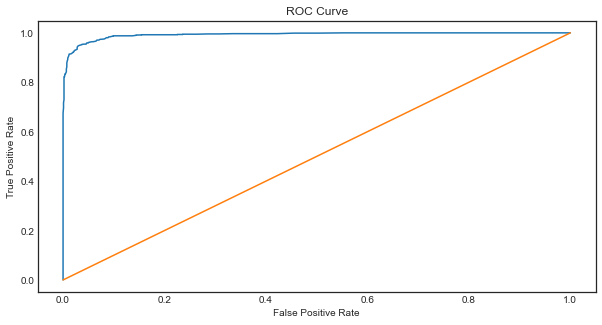

In [63]:
fpr,tpr,thresholds = roc_curve(y_test,predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [64]:
# Custom Input Function

In [65]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print("Invalid Statement.")

In [66]:
def sentiment_predictor(input):
    input = text_transformation(input)
    transformed_input = cv.transform(input)
    prediction = rfc.predict(transformed_input)
    expression_check(prediction)

In [67]:
input1 = ["Geico pissed me off today."]
input2 = ["I bought a new phone and it's so good."]
sentiment_predictor(input1)
sentiment_predictor(input2)

Input statement has Negative Sentiment.
Input statement has Positive Sentiment.
